<a href="https://colab.research.google.com/github/pdijour/BME547/blob/master/project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model as lm
from sklearn import metrics
import torch
from numpy.lib.stride_tricks import sliding_window_view

sns.set()

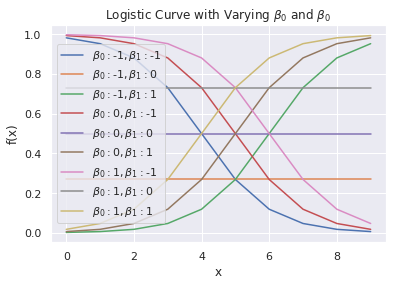

In [3]:
## Question 1

x = np.arange(-5,5)
B0 = [-1,0,1]
B1 = [-1,0,1]

plt.figure()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Logistic Curve with Varying ' + r'$\beta_0$ and $\beta_0$')

for i in B0:
    for j in B1:
        f = np.exp(i+j*x)/(1+np.exp(i+j*x))
        plt.plot(f, label=r'$\beta_0: $' + str(i) + r'$, \beta_1: $' + str(j))
plt.legend()

In [4]:
## Question 2 - Load Data

df = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv")
df = df.drop(['depth', 'table', 'x', 'y', 'z'], axis = 1)
df_onehot = pd.get_dummies(df)
df_onehot = df_onehot.rename(columns = {'cut_Very Good':'cut_Very'})

# df['cut'] = df['cut'].replace(['Fair','Good','Very Good','Premium','Ideal'],[0,1,2,3,4])
df_onehot.head(4)

,carat,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,326,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,326,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,327,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,334,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [5]:
## Question 2 - Train Data and Calculate MSE

trainFraction = .75

sample = np.random.uniform(size = len(df_onehot.index)) < trainFraction

## One hot encoded - assignment asks for this
trainingDat = df_onehot[sample]
testingDat = df_onehot[~sample]

word='price ~ carat'

for i in df_onehot.columns:
    if i != 'carat' and i != 'price':
        word = word + ' + ' + i

results = smf.ols(word, data = trainingDat).fit()
# print(results.summary2())
# print(np.sqrt(results.mse_resid))

## Not one hot encoded (using C())
trainingDat2 = df[sample]
testingDat2 = df[~sample]

results2 = smf.ols('price ~ carat + C(cut) + C(color) + C(clarity)', data=trainingDat2).fit()

# print(results2.summary2())
print(np.sqrt(results2.mse_resid))


1155.2365685682785


In [6]:
## Question 3 - Load Data

countries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

def get_country(df, country):
    country = df[df['Country/Region'] == country].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1).unstack()
    country = np.asarray(country)
    country = country[1 : country.size] - country[0 : (country.size - 1)]
    country = country[np.min(np.where(country !=  0)) : country.size]

    diff = np.diff(country)
    y = np.array([1 if i>0 else 0 for i in diff])[4:]
    x = sliding_window_view(diff, 4)[:-1]

    return x,y


# Part 1: within country forecasting accuracy
x,y = get_country(countries,'China')


trainFraction = .75
sample = np.random.uniform(size = len(x)) < trainFraction

xtrain = x[ sample]
ytrain = y[ sample]
xtest =  x[~sample]
ytest =  y[~sample]

lr = lm.LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(xtrain, ytrain)

yhat_test = fit.predict(xtest)
within_country_accuracy = np.mean(yhat_test == ytest)
print(within_country_accuracy)

0.774138352481056


In [10]:
# Part 2: between country forecasting accuracy

(xtest,ytest) = get_country(countries,'India')

lr = lm.LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(x, y)

yhat_test = fit.predict(xtest)
between_country_accuracy = np.mean(yhat_test == ytest)
print(between_country_accuracy)

0.45191313340227507
